In [55]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
from tqdm import tqdm
SAMPLE_RATE = 22050  


In [56]:
CSV_FILE = "data.csv"


In [57]:
df = pd.read_csv(CSV_FILE)


In [58]:
label_mapping = {'dysarthria': 1, 'non_dysarthria': 0}


In [59]:
missing_files = []


In [60]:
def extract_features(audio_path):
    if not os.path.exists(audio_path):
        missing_files.append(audio_path)
        return None

    try:
        audio, sr = librosa.load(audio_path, sr=SAMPLE_RATE)
        n_fft = min(2048, len(audio) - 1)  

        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13, n_fft=n_fft)
        mfcc_mean = np.mean(mfcc, axis=1)

        chroma = librosa.feature.chroma_stft(y=audio, sr=sr, n_fft=n_fft)
        chroma_mean = np.mean(chroma, axis=1)

        spec_contrast = librosa.feature.spectral_contrast(y=audio, sr=sr, n_fft=n_fft)
        spec_contrast_mean = np.mean(spec_contrast, axis=1)

        feature_vector = np.concatenate([mfcc_mean, chroma_mean, spec_contrast_mean])

        return feature_vector
    
    except Exception as e:
        print(f"Error processing {audio_path}: {e}")
        return None

In [61]:
features, labels = [], []
for _, row in tqdm(df.iterrows(), total=len(df), desc="Extracting Features"):
    feature_vector = extract_features(row['filename'])
    if feature_vector is not None:
        features.append(feature_vector)
        labels.append(label_mapping[row['is_dysarthria']])  


Extracting Features:   4%|██▌                                                        | 85/2000 [00:01<00:36, 52.25it/s]E:\Python\Lib\site-packages\librosa\core\pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
Extracting Features:  30%|█████████████████▎                                        | 598/2000 [00:11<00:28, 48.43it/s]C:\Users\Asus-2023\AppData\Local\Temp\ipykernel_18144\2051965969.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(audio_path, sr=SAMPLE_RATE)
E:\Python\Lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Extracting Features:  30%|█████████████████▌                                        | 606/2000 [00:12<00:27, 51.33it/s]

Error processing torgo_data/dysarthria_female/F01_Session1_0068.wav: 


Extracting Features:  78%|████████████████████████████████████████████▏            | 1552/2000 [00:30<00:10, 42.41it/s]E:\Python\Lib\site-packages\librosa\feature\spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
Extracting Features: 100%|█████████████████████████████████████████████████████████| 2000/2000 [00:40<00:00, 49.31it/s]


In [62]:
features = np.array(features, dtype=np.float32)
labels = np.array(labels, dtype=int)

np.save("features.npy", features)
np.save("labels.npy", labels)

In [64]:
import numpy as np
from sklearn.model_selection import train_test_split

features = np.load("features.npy")
labels = np.load("labels.npy")

X_train, X_temp, y_train, y_temp = train_test_split(features, labels, test_size=0.3, random_state=42, stratify=labels)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Train Shape: {X_train.shape}, Labels: {y_train.shape}")
print(f"Validation Shape: {X_val.shape}, Labels: {y_val.shape}")
print(f"Test Shape: {X_test.shape}, Labels: {y_test.shape}")

Train Shape: (1399, 32), Labels: (1399,)
Validation Shape: (300, 32), Labels: (300,)
Test Shape: (300, 32), Labels: (300,)


In [65]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout

model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),  
    Dropout(0.3), 
    Dense(64, activation='relu'),  
    Dropout(0.3),
    Dense(32, activation='relu'),  
    Dense(1, activation='sigmoid') 
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    X_train, y_train,
    epochs=500,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1  
)

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print(f"\nTest Accuracy: {test_acc:.4f}")

Epoch 1/500


E:\Python\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5157 - loss: 5.6934 - val_accuracy: 0.6100 - val_loss: 0.6240
Epoch 2/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6017 - loss: 1.6457 - val_accuracy: 0.5333 - val_loss: 0.7235
Epoch 3/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5822 - loss: 1.2553 - val_accuracy: 0.4333 - val_loss: 0.8120
Epoch 4/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5715 - loss: 0.9814 - val_accuracy: 0.5000 - val_loss: 0.7263
Epoch 5/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5735 - loss: 0.9368 - val_accuracy: 0.6200 - val_loss: 0.6421
Epoch 6/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5951 - loss: 0.8057 - val_accuracy: 0.5000 - val_loss: 0.6823
Epoch 7/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5631 - loss: 0.7672 - val_accuracy: 0.7467 - val_loss: 0.6169
Epoch 8/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6140 - loss: 0.7304 - val_accuracy: 0.7733 - val_loss: 0.5

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9267 - loss: 0.1797 - val_accuracy: 0.9233 - val_loss: 0.2208
Epoch 102/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9218 - loss: 0.2202 - val_accuracy: 0.9167 - val_loss: 0.2396
Epoch 103/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9073 - loss: 0.2258 - val_accuracy: 0.9067 - val_loss: 0.2429
Epoch 104/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9135 - loss: 0.2198 - val_accuracy: 0.9000 - val_loss: 0.2571
Epoch 105/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9358 - loss: 0.1957 - val_accuracy: 0.9167 - val_loss: 0.2367
Epoch 106/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9135 - loss: 0.2150 - val_accuracy: 0.9100 - val_loss: 0.2216
Epoch 107/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9197 - loss: 0.2348 - val_accuracy: 0.9333 - val_loss: 0.2166
Epoch 108/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9217 - loss: 0.2286 - val_accuracy: 0.9100 -

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9372 - loss: 0.1528 - val_accuracy: 0.9267 - val_loss: 0.1921
Epoch 202/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9353 - loss: 0.1657 - val_accuracy: 0.9200 - val_loss: 0.2120
Epoch 203/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9397 - loss: 0.1535 - val_accuracy: 0.9133 - val_loss: 0.1859
Epoch 204/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9453 - loss: 0.1419 - val_accuracy: 0.9367 - val_loss: 0.1899
Epoch 205/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9434 - loss: 0.1405 - val_accuracy: 0.9367 - val_loss: 0.2008
Epoch 206/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9581 - loss: 0.1277 - val_accuracy: 0.9500 - val_loss: 0.1891
Epoch 207/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9637 - loss: 0.1146 - val_accuracy: 0.9300 - val_loss: 0.1915
Epoch 208/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9456 - loss: 0.1671 - val_accuracy: 0.9333 -

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9536 - loss: 0.1296 - val_accuracy: 0.9200 - val_loss: 0.1826
Epoch 302/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9611 - loss: 0.1096 - val_accuracy: 0.9367 - val_loss: 0.1570
Epoch 303/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9552 - loss: 0.1342 - val_accuracy: 0.9300 - val_loss: 0.1536
Epoch 304/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9432 - loss: 0.1351 - val_accuracy: 0.9333 - val_loss: 0.1434
Epoch 305/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9506 - loss: 0.1454 - val_accuracy: 0.9433 - val_loss: 0.1698
Epoch 306/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9596 - loss: 0.1071 - val_accuracy: 0.9533 - val_loss: 0.1496
Epoch 307/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9497 - loss: 0.1629 - val_accuracy: 0.9567 - val_loss: 0.1302
Epoch 308/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9557 - loss: 0.1172 - val_accuracy: 0.9400 -

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9626 - loss: 0.1082 - val_accuracy: 0.9433 - val_loss: 0.1438
Epoch 402/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9591 - loss: 0.1235 - val_accuracy: 0.9533 - val_loss: 0.1359
Epoch 403/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9602 - loss: 0.1054 - val_accuracy: 0.9500 - val_loss: 0.1315
Epoch 404/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9510 - loss: 0.1325 - val_accuracy: 0.9367 - val_loss: 0.1545
Epoch 405/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9576 - loss: 0.1109 - val_accuracy: 0.9433 - val_loss: 0.1419
Epoch 406/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9632 - loss: 0.1188 - val_accuracy: 0.9467 - val_loss: 0.1587
Epoch 407/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9676 - loss: 0.1116 - val_accuracy: 0.9433 - val_loss: 0.1525
Epoch 408/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9617 - loss: 0.1022 - val_accuracy: 0.9333 -

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9603 - loss: 0.6433 

Test Accuracy: 0.9600


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
                precision    recall  f1-score   support

Non-Dysarthria       0.94      0.99      0.96       150
    Dysarthria       0.99      0.93      0.96       150

      accuracy                           0.96       300
     macro avg       0.96      0.96      0.96       300
  weighted avg       0.96      0.96      0.96       300



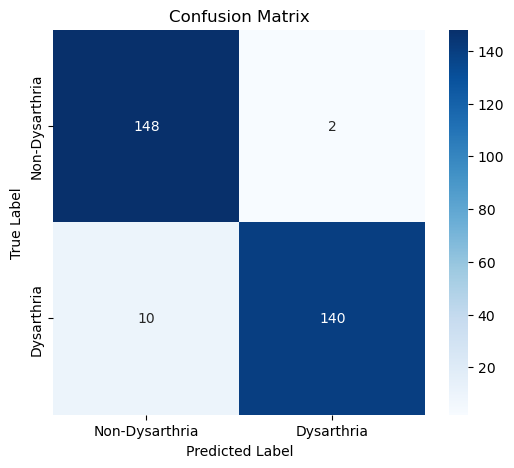

In [66]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  
print(classification_report(y_test, y_pred, target_names=['Non-Dysarthria', 'Dysarthria']))

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Dysarthria', 'Dysarthria'], yticklabels=['Non-Dysarthria', 'Dysarthria'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


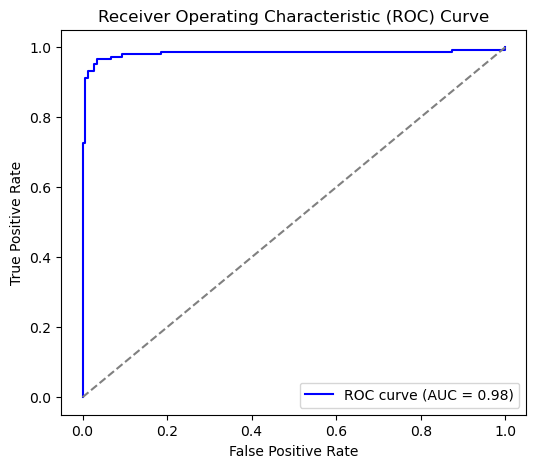

In [67]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, model.predict(X_test))
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.show()


In [68]:
model.save("dysarthria_model.keras")